# **Image classification using VGG19 and Inceptionv3**

**Mount the drive**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

drive  sample_data


GPU was connected to the runtime, for efficiency of the model training. The device is connected.

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


All packages required have been imported.

In [5]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.inception_v3 import InceptionV3

sys.version

'3.6.9 (default, Apr 18 2020, 01:56:04) \n[GCC 8.4.0]'

In [6]:
cd /content/drive/My Drive/data

/content/drive/My Drive/data


Unzip and Load the data.

In [7]:
!unzip 17FlowerDataset.zip

Archive:  17FlowerDataset.zip
replace 17FlowerDataset/17Flowers-GroundTruth.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# base_path = 'Dataset/flowers/'
base_path = '/content/drive/My Drive/data/17FlowerDataset'

categories = ["Daffodil",'Snowdrop', 'LilyValley', 'Bluebell',
           'Crocus', 'Iris', 'Tigerlily', 'Tulip',
           'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot',
            'Dandelion', 'Cowslip', 'Buttercup', 'Windflower',
            'Pansy']

Load File names

In [0]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [10]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


Load Images

In [0]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [12]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


Minimal shape of all images calculation.

In [13]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

500,499 is the min shape for Daffodil
499,499 is the min shape for Snowdrop
499,499 is the min shape for LilyValley
499,499 is the min shape for Bluebell
499,499 is the min shape for Crocus
499,499 is the min shape for Iris
499,499 is the min shape for Tigerlily
499,499 is the min shape for Tulip
499,499 is the min shape for Fritillary
499,499 is the min shape for Sunflower
499,500 is the min shape for Daisy
499,499 is the min shape for ColtsFoot
499,499 is the min shape for Dandelion
499,499 is the min shape for Cowslip
499,499 is the min shape for Buttercup
499,499 is the min shape for Windflower
499,499 is the min shape for Pansy


convert cv2 BGR format to RGB for showing¶

In [0]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

In [15]:
print(len(images))

17


Sample images for some flowers 

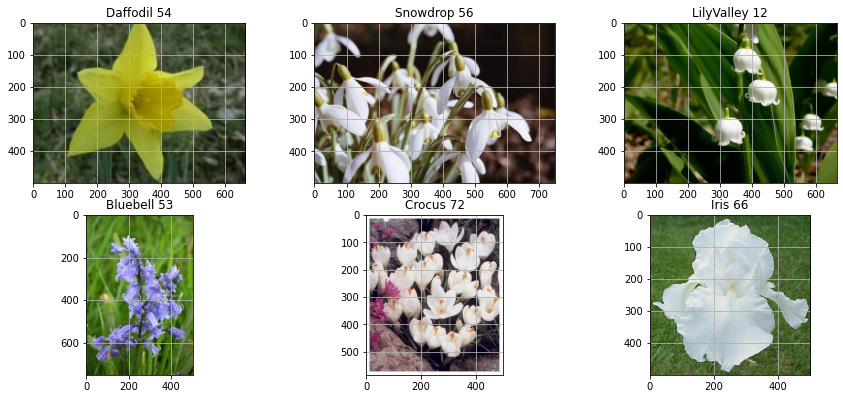

In [16]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images[:6]):
    plt.subplot(3,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i]+' '+str(idx))
plt.show()

Images resized to 256 by 256

(500, 514, 3)
(256, 256, 3)


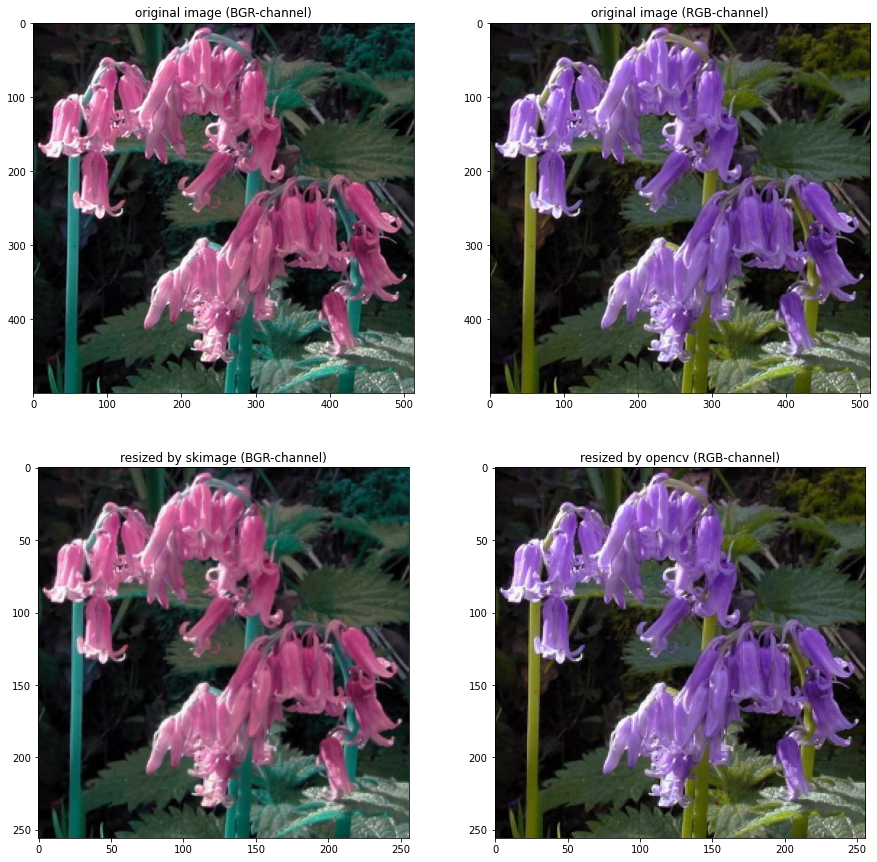

In [17]:
img_width, img_height = 256, 256

img = images[3][17]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [0]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

Split dataset to 80% training and 20% validation.

In [0]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

Creat labels

In [20]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
sum of train images: 1088
[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
sum of val_images: 272


Image data conversion to numpy array
Convert class labels to binary class labels

In [0]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

Set a seed and shufle data and the labels.

In [22]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (1088, 256, 256, 3)
train labels: (1088,)

After converting
train data: (1088, 256, 256, 3)
train labels: (1088, 17)


In [0]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [24]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (1088, 256, 256, 3)
shape of train labels: (1088, 17)
shape of val data: (272, 256, 256, 3)
shape of val labels: (272, 17)


Build the model.
1. model created from scratch.
2. model created using VGG19
3. model created using inceptionV3

In [0]:
def create_model_from_scratch():

    """
     train from scratch
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu', name='conv_1'))
    model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
    model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dense(len(categories), name='output'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [0]:
def create_model_from_VGG19():
    """
      use VGG19
    """
    model = VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
    
    # Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
    for layer in model.layers[:1]:
      layer.trainable = False
      
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)
    
    # creating the final model 
    final_model = Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return final_model

In [0]:
def create_model_from_InceptionV3():

    """
    Use InceptionV3
    """
    model = InceptionV3(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3))
    
    for layer in model.layers[:1]:
      layer.trainable = False
      
    #Adding custom Layers 
    x = model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(categories), activation="softmax")(x)
    
    # creating the final model 
    final_model = Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return final_model

In [28]:
model_scratch = create_model_from_scratch()
model_scratch.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 254, 254, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 127, 127, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 125, 125, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0

In [29]:
model_VGG19 = create_model_from_VGG19()
model_VGG19.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [30]:
model_Inception_V3 = create_model_from_InceptionV3()
model_Inception_V3.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization[0][0]        
___________________________

# **Input data preparation.**

In [0]:
# Parameters
batch_size = 32
epochs = 50


# **Model generator creation.**

In [0]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

# **Train the model** 
by fitting with generator.

In [37]:
start = time.time()

model_scratch_info = model_scratch.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,    
    epochs=epochs, 
    validation_steps=len(val_data)/batch_size, 
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/50
34/34 - 17s - loss: 0.7935 - acc: 0.7629 - val_loss: 1.0144 - val_acc: 0.7647
Epoch 2/50
34/34 - 17s - loss: 0.7840 - acc: 0.7647 - val_loss: 0.7493 - val_acc: 0.7647
Epoch 3/50
34/34 - 17s - loss: 0.8123 - acc: 0.7656 - val_loss: 0.6928 - val_acc: 0.7647
Epoch 4/50
34/34 - 17s - loss: 0.6949 - acc: 0.7647 - val_loss: 0.7015 - val_acc: 0.7941
Epoch 5/50
34/34 - 17s - loss: 0.6702 - acc: 0.7693 - val_loss: 0.6145 - val_acc: 0.7647
Epoch 6/50
34/34 - 17s - loss: 0.6478 - acc: 0.7684 - val_loss: 0.5864 - val_acc: 0.7684
Epoch 7/50
34/34 - 17s - loss: 0.6368 - acc: 0.7776 - val_loss: 0.5777 - val_acc: 0.7537
Epoch 8/50
34/34 - 17s - loss: 0.6045 - acc: 0.7757 - val_loss: 0.5778 - val_acc: 0.7831
Epoch 9/50
34/34 - 17s - loss: 0.6736 - acc: 0.7675 - val_loss: 0.6326 - val_acc: 0.7721
Epoch 10/50
34/34 - 17s - loss: 0.6235 - acc: 0.7684 - val_loss: 0.6416 - val_acc: 0.7647
Epoch 11/50
34/34 - 17s - loss: 0.5948 - acc: 0.7785 - val_loss: 0.5647 - val_acc: 0.7831
Epoch 12/50
34/34 -

In [38]:
start = time.time()

model_VGG19_info = model_VGG19.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator,
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_VGG19 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/50
34/34 - 21s - loss: 0.8874 - acc: 0.7647 - val_loss: 0.8830 - val_acc: 0.7647
Epoch 2/50
34/34 - 21s - loss: 0.8780 - acc: 0.7647 - val_loss: 0.8615 - val_acc: 0.7647
Epoch 3/50
34/34 - 21s - loss: 0.8969 - acc: 0.7647 - val_loss: 0.8604 - val_acc: 0.7647
Epoch 4/50
34/34 - 21s - loss: 0.8985 - acc: 0.7647 - val_loss: 0.8647 - val_acc: 0.7647
Epoch 5/50
34/34 - 21s - loss: 0.8963 - acc: 0.7647 - val_loss: 0.8769 - val_acc: 0.7647
Epoch 6/50
34/34 - 21s - loss: 0.8859 - acc: 0.7647 - val_loss: 0.8731 - val_acc: 0.7647
Epoch 7/50
34/34 - 21s - loss: 0.8997 - acc: 0.7647 - val_loss: 0.8871 - val_acc: 0.7647
Epoch 8/50
34/34 - 21s - loss: 0.8878 - acc: 0.7647 - val_loss: 0.8659 - val_acc: 0.7647
Epoch 9/50
34/34 - 21s - loss: 0.8852 - acc: 0.7647 - val_loss: 0.8797 - val_acc: 0.7647
Epoch 10/50
34/34 - 21s - loss: 0.8868 - acc: 0.7647 - val_loss: 0.8680 - val_acc: 0.7647
Epoch 11/50
34/34 - 21s - loss: 0.8664 - acc: 0.7647 - val_loss: 0.8347 - val_acc: 0.7647
Epoch 12/50
34/34 -

In [39]:
start = time.time()

model_Inception_V3_info = model_Inception_V3.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator,
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_Inception_V3 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )



Epoch 1/50
34/34 - 20s - loss: 5.1729 - acc: 0.6939 - val_loss: 80397952.0000 - val_acc: 0.7647
Epoch 2/50
34/34 - 18s - loss: 0.9557 - acc: 0.7638 - val_loss: 16175706.0000 - val_acc: 0.7647
Epoch 3/50
34/34 - 18s - loss: 0.8416 - acc: 0.7647 - val_loss: 85068.2578 - val_acc: 0.7647
Epoch 4/50
34/34 - 18s - loss: 0.7801 - acc: 0.7638 - val_loss: 1554.2671 - val_acc: 0.7647
Epoch 5/50
34/34 - 18s - loss: 0.7004 - acc: 0.7638 - val_loss: 4.4516 - val_acc: 0.7647
Epoch 6/50
34/34 - 18s - loss: 4.5304 - acc: 0.7619 - val_loss: 2042.2156 - val_acc: 0.0772
Epoch 7/50
34/34 - 18s - loss: 2.5449 - acc: 0.6857 - val_loss: 75341.0234 - val_acc: 0.7647
Epoch 8/50
34/34 - 18s - loss: 0.9749 - acc: 0.7528 - val_loss: 1.6762 - val_acc: 0.7647
Epoch 9/50
34/34 - 18s - loss: 0.9591 - acc: 0.7647 - val_loss: 1.3033 - val_acc: 0.7647
Epoch 10/50
34/34 - 18s - loss: 0.9160 - acc: 0.7647 - val_loss: 1.0495 - val_acc: 0.7610
Epoch 11/50
34/34 - 18s - loss: 0.9198 - acc: 0.7647 - val_loss: 1.0114 - val_acc

In [0]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

# **Predict and evaluate the model**

In [0]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

model_scratch


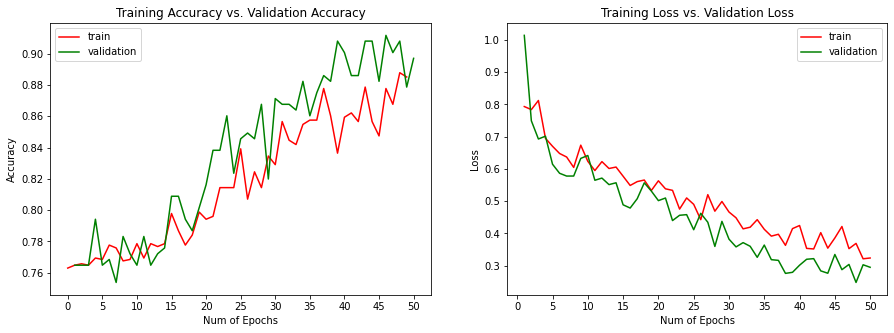

model_VGG19


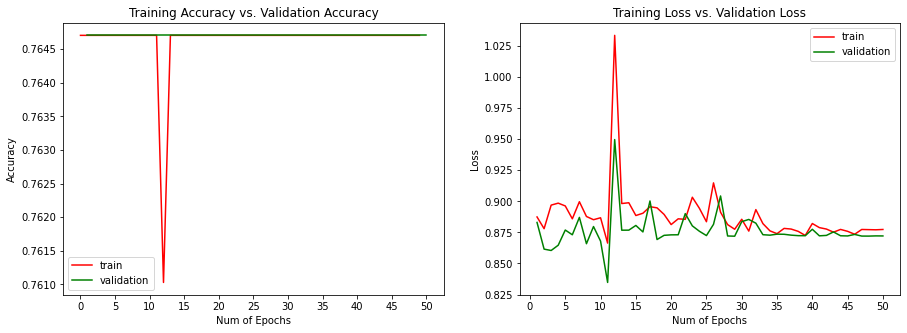

model_Inception_V3


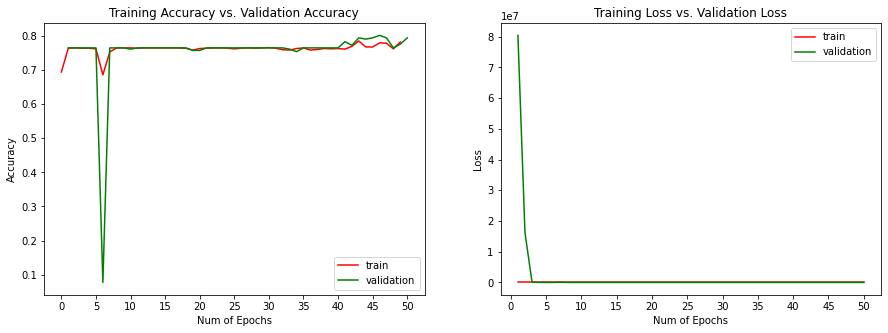

In [42]:
plot_model_history('model_scratch', model_scratch_info.history, epochs)
plot_model_history('model_VGG19', model_VGG19_info.history, epochs)
plot_model_history('model_Inception_V3', model_Inception_V3_info.history, epochs)

# **Predict one image**

In [0]:
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

Bluebell 25%


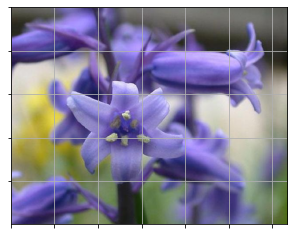

In [44]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_Inception_V3)

test_img = cv2.imread('/content/drive/My Drive/data/17FlowerDataset/Bluebell/image_0241.jpg')
pred, probability = predict_one_image(test_img, model_Inception_V3)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

In [0]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

# **InceptionV3** performed better than other two models.

Below is prediction from the model.


Model trained from Inception_V3


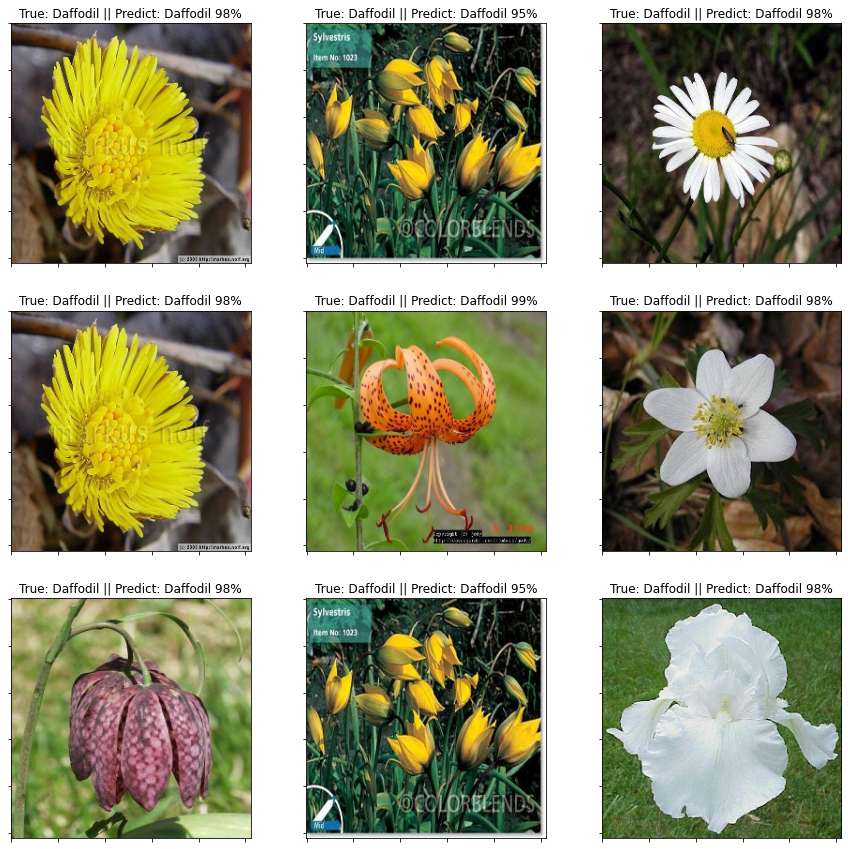

In [46]:
print("Model trained from Inception_V3")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(17)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model_Inception_V3)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()